In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from PIL import Image
#!pip install torchsummary
import random
from torchsummary import summary
import zipfile
import shutil
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [2]:
with zipfile.ZipFile("dogs-vs-cats/train.zip","r") as z:
    z.extractall("data/")
with zipfile.ZipFile("dogs-vs-cats/test1.zip", "r") as z:
    z.extractall('data/')

In [3]:
train_dir = "./data/train"
print(f"Training images: {len(os.listdir(train_dir))}")

Training images: 25000


In [4]:
# reorganizing file structure

for file in os.listdir(train_dir):                
    if file.startswith("cat"):
        if not os.path.exists(os.path.join(train_dir, "cat")):
            os.mkdir(os.path.join(train_dir, "cat"))
        src_path = os.path.join(train_dir, file) 
        dst_path = os.path.join(os.path.join(train_dir, "cat"), file) 
        shutil.move(src_path, dst_path)
            
    else:
        if not os.path.exists(os.path.join(train_dir, "dog")):
                os.mkdir(os.path.join(train_dir, "dog"))
        src_path = os.path.join(train_dir, file) 
        dst_path = os.path.join(os.path.join(train_dir, "dog"), file) 
        shutil.move(src_path, dst_path)
        
# generating a validation set with 20% of images

for cl in ['cat' , 'dog']:
    files = os.listdir(os.path.join(train_dir, cl))
    random.seed(12345)
    random.shuffle(files)
    size = int(len(files)*0.2)
    selected_files = [files[n] for n in range(size)]
    for file in selected_files:
        
        src_path = os.path.join(train_dir, cl, file)
        
        if not os.path.exists(os.path.join("./data",'valid')):
            os.mkdir(os.path.join("./data/valid"))
        
        if not os.path.exists(os.path.join("./data",'valid', cl)):
            os.mkdir(os.path.join("./data/valid",cl))
        
        dst_path = os.path.join("./data/valid/", cl, file)
        shutil.move(src_path, dst_path)

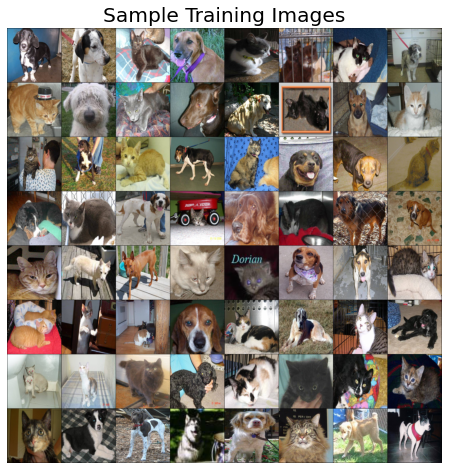

In [14]:
train_dir = "./data/train"
valid_dir = "./data/valid"


image_size = 200
batch_size = 64

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    #transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_dir, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [10]:
print('Training data')
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))

Training data
Classes: ['cat', 'dog']
Class count: 10000, 10000
Samples: 20000


In [ ]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X).flatten()            # Forward pass to get output
            loss = criterion(y_hat, y.type(torch.float32))  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [32]:
class bitmoji_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(324, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out